In [21]:
import csv
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib.pylab import subplots
import matplotlib.pyplot as plt

In [22]:
def cleandata(ori):
    '''
    This function is intended to clean the bad data(like "no data/unknow/NaN") for later processing.
    Inputs: 
    ori: original file name
    cor: the target correlation datasets:['subject_sex','subject_age','searched']
    Outputs:
    cleaned: the cleaned file name
    '''
    
    assert isinstance(ori,str)
    cleaned = './datasets/gender_age_searched_cleaned.csv'
    with open(ori, mode='r') as in_file, open(cleaned, mode='w') as out_file:
        csv_reader = csv.DictReader(in_file)
        csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        line_count = 0
        empty_arrest_rows_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                csv_writer.writerow(row)
                line_count += 1
            else:
                if (row["searched"] == 'Y' or row["searched"] == 'N') and len(row["subject_age"]) == 2 and row["subject_age"] != 'No Age' and (row["subject_sex"] == 'M' or row["subject_sex"] == 'F'):
                    to_write = []
                    for key, val in row.items():
                        to_write.append(val)
                    csv_writer.writerow(to_write)
                else:
                    empty_arrest_rows_count += 1
                line_count += 1
        print(f'Processed {line_count} lines.')
        print(f'{empty_arrest_rows_count} emty lines.')#clean data
    return cleaned
    

In [23]:
def read_data(cleaned):
    assert isinstance(cleaned,str)
    
    dataset = pd.read_csv(cleaned)
    return dataset

In [24]:
def create_data(dataset,mode='ratio'):
    
    assert isinstance(dataset,pd.core.frame.DataFrame)
    assert isinstance(mode,str) and (mode == 'ratio' or mode =='stopped' or mode == 'searched' )
    
    #create stopped dataset
    male_stopped = defaultdict(int)
    female_stopped = defaultdict(int)
    
    for i in range(len(dataset['subject_age'])):#count stopped times
        if dataset['subject_sex'][i] == 'M':
            male_stopped[dataset['subject_age'][i]] += 1
    for i in range(len(dataset['subject_age'])):
        if dataset['subject_sex'][i] == 'F':
            female_stopped[dataset['subject_age'][i]] += 1

    male_stopped_sort = sorted(male_stopped.items(), key=lambda item: item[0])
    female_stopped_sort = sorted(female_stopped.items(), key=lambda item: item[0])

    male_stopped_array = np.transpose(np.array(male_stopped_sort))
    female_stopped_array = np.transpose(np.array(female_stopped_sort))
    
    #create searched dataset
    male_searched=defaultdict(int)
    female_searched=defaultdict(int)
    
    for i in range(len(dataset['subject_age'])):#count searched times
        if dataset['searched'][i] == 'Y':
            if dataset['subject_sex'][i] == 'M':
                male_searched[dataset['subject_age'][i]] += 1
            elif dataset['subject_sex'][i] == 'F':
                female_searched[dataset['subject_age'][i]] += 1

    male_searched_sort = sorted(male_searched.items(), key=lambda item: item[0])#sort for plot
    female_searched_sort = sorted(female_searched.items(), key=lambda item: item[0])

    male_searched_array = np.transpose(np.array(male_searched_sort))#change to numpy for plot
    female_searched_array = np.transpose(np.array(female_searched_sort))

    #create searched/stopped dataset
    male_ratio = defaultdict(int)
    female_ratio = defaultdict(int)

    for i in male_searched.keys():
        male_ratio[i] = male_searched[i] / male_stopped[i]

    for i in female_searched.keys():
        female_ratio[i] = female_searched[i] / female_stopped[i]

    male_ratio_sort = sorted(male_ratio.items(), key=lambda item: item[0])
    female_ratio_sort = sorted(female_ratio.items(), key=lambda item: item[0])

    male_ratio_array = np.transpose(np.array(male_ratio_sort))
    female_ratio_array = np.transpose(np.array(female_ratio_sort))
    
    if mode == 'ratio':
        return male_ratio_array, female_ratio_array
    elif mode == 'stopped':
        return male_stopped_array, female_stopped_array
    elif mode == 'searched':
        return male_searched_array, female_searched_array



In [25]:
def plot_data(pic='ratio'):
    cleanedcsv = cleandata('./datasets/vehicle_stops_2016_datasd_original.csv')
    dataset = read_data(cleanedcsv)
    male_stopped_array, female_stopped_array = create_data(dataset,mode='stopped')
    male_searched_array, female_searched_array = create_data(dataset,mode='searched')
    male_ratio_array, female_ratio_array = create_data(dataset,mode='ratio')
    if pic == 'ratio':
        return male_ratio_array, female_ratio_array
    elif pic == 'stopped':
        return male_stopped_array, female_stopped_array
    elif pic == 'searched':
        return male_searched_array, female_searched_array

Column names are stop_id, stop_cause, service_area, subject_race, subject_sex, subject_age, timestamp, stop_date, stop_time, sd_resident, arrested, searched, obtained_consent, contraband_found, property_seized
Processed 103051 lines.
23109 emty lines.


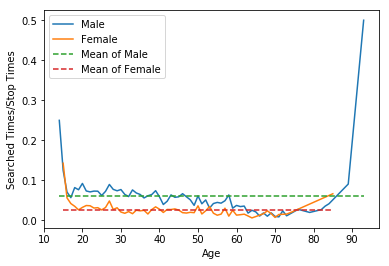

In [26]:
if (__name__ == "__main__"):
    male_ratio_array, female_ratio_array = plot_data(pic='ratio')
    fig,ax=subplots()
    ax.plot(male_ratio_array[0],male_ratio_array[1],female_ratio_array[0],female_ratio_array[1])#all data
    ax.plot(male_ratio_array[0],len(male_ratio_array[0]+1)*[np.mean(male_ratio_array[1])],\
    female_ratio_array[0],len(female_ratio_array[0]+1)*[np.mean(female_ratio_array[1])],linestyle="--")
    ax.legend(('Male','Female','Mean of Male','Mean of Female'),loc='best')
    plt.xlabel('Age')
    plt.ylabel('Searched Times/Stop Times')